# Load Prediction of Scaife-Hall:

In this IPython Notebook, power consumption and Outdoor Air temperature data is parsed from CSV files(enfuse dataset/iwp dataset) to predict Future Consumption of Power.


<font color='red'>Please make sure Python and other necessary packages (using pip to install *ipython,  matplotlib, numpy, scikit-learn*) are installed.</font> 

## Importing libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import csv
from datetime import timedelta, datetime
from dateutil.parser import *
import os
%matplotlib inline

## Loading datasets:

In [8]:
Data_path = 'Datasets/'
%ls $Data_path

Filtered.csv* Outdoor_temp/ enfuse/


In [187]:
csv_path_p = Data_path + 'enfuse/'
csv_files_p = os.listdir(csv_path)

In [188]:
csv_path_t = Data_path + 'Outdoor_temp/'
csv_files_t = os.listdir(csv_path_t)

## Creating the database:
The existing files consist of per minute power consumption measurements (*enfuse*) and Outdoor Air temperature measurements (*Intelligent workspace: CMU*).


In order to run regression measurements for every *15 minutes* are required, which is performed by the following functions:

In [193]:
def read_file(path,filename):
    data=[];
    f = open(path+'/'+filename,'rU')
    lines =f.readlines()
    csvlines = csv.reader(lines,skipinitialspace=True,dialect=csv.excel_tab)
    for line in csvlines:
        data.append(line)
    f.close()
    return data


def load_temp(path,files,t_0):
    out=read_file(path,files)
    data={"Timestamp":np.array([parse(out[i][0]) for i in range(1,len(out))]),
      "Temperature":np.array([out[i][1] for i in range(1,len(out))])
        }
    y=list(data["Timestamp"]).index(t_0)
    idx=np.arange(y,y+96*15,15)
    temp=data["Temperature"][idx]
    
    #Removing the No data points and linearly interpolating
    i_null=np.where(temp=='No Data')
    p=np.arange(96)
    t=zip(p,temp)
    for j in i_null[0]:
        t[j]=[]
    for i in range(len(i_null[0])):
        t.remove([])
        
    clean_t=np.interp(p,[i[0] for i in t],[float(i[1]) for i in t])
    return clean_t
    
    
def create_database(files_p):
    out=read_file(csv_path_p,files_p)
    
    data={"Timestamp": np.array([parse(out[i][5]) for i in range(1,len(out))]),
      "Power": np.array([float(out[i][11]) for i in range(1,len(out))])
    }
    
    k=data['Timestamp'][0].weekday() #time of week indicator(Will consider only Mondays-Fridays)
    if (k!=5 and k!=6):
        time=np.array([i.hour*60 + i.minute for i in data['Timestamp']])
        idx=[np.where(time==i) for i in np.unique(time)]
        power=[np.sum(data["Power"][i]) for i in idx]
        
        #15 minute time intervals, based on regression-model:
        clean_p=np.interp(np.arange(0,1440,15),np.unique(time),power)
        t=np.array([data["Timestamp"][0]+timedelta(minutes=15*i) for i in range(96)])
        clean_t=load_temp(csv_path_t,csv_files_t[0],t[0])
        out=zip(t,clean_p,clean_t)
    return out



    

In [195]:
sc_data=[]
for i in csv_files_p:
        sc_data.append(create_database(i))

In [220]:
data_r=[]
for i in range(len(sc_data)):
    for j in range(len(sc_data[i])):
        data_r.append(sc_data[i][j])

## Regression:

The Regression is based on the following equation:

$\hat{L}_o(t_i,(T(t_i)))=\alpha_i + \sum_{j=1}^{j=6} \beta_jT_{c,j}(t_i)\\
\hat{L}_u(t_i,(T(t_i)))=\alpha_i + \beta_\mu T(t_i)$

Where i $\in$ [1,480] and j $\in$ [1,6], and *o* corresponds to occupied, *u* corresponds to un occupied times.

It consists of two main parameters: A piecewise continuous time function and a Time of week indicator variable.

In [219]:
data={
    "Timestamp":np.array([i[0] for i in data_r]),
    "Power":np.array([i[1] for i in data_r]),
    "Temperature":np.array([i[2] for i in data_r])}

### Piece-wise continuous function:

To achieve piecewise linearity and continuity, the outside air
temperature at time t￼ (which occurs in time-of-week interval ), ￼ T(t$_i$) ￼ , is broken into six component temperatures(between the minima and the maxima),T$_{c,j}$(t$_i$)
with j$\in$(1,6).
Each T$_{c,j}$(t$_i$) is multiplied by $\beta_j$￼ ￼ and then summed to determine the temperature-dependent load. B$_k$, k$\in$(1,5) is considered to be the bounds of the temperature intervals.

It follows the following algorithm:

1. If T(t$_i$) $>$ B$_1$, then T$_{c,1}$(t$_i$) = B$_1$, otherwise T$_{c,1}$(t$_i$) = T(t$_i$) and T$_{c,m}$(t$_i$) = 0 for m$\in$(2,6).  

2. For n = 2...6, if T(t$_i$) $>$ B$_n$ then T$_{c,n}$(t$_i$) = B$_n$-B$_{n-1}$ and T$_{c,m}$(t$_i$) = 0 for m$\in$(n+1,6).

3. If T(t$_i$) $>$ B$_5$,then T$_{c,5}$(t$_i$) = B$_5$-B$_4$ and T$_{c,6}$(t$_i$) = T(t$_i$) - B$_5$.


In [207]:
def piece_wise_continuity(Ti):
    steps=np.linspace(np.min(Ti),np.max(Ti),7)
    B=steps[1:6]
    Tc=np.zeros(6)
    indext=[]
    for i in range(0,len(Ti)):
        if(Ti[i]<B[0]):
            Tc[0]=Ti[i]
        else:
            Tc[0]=B[0]
            if(Ti[i]<B[1]):
                Tc[1]=Ti[i]-B[0]
            else:
                Tc[1]=B[1]-[0]
                if(Ti[i]<B[2]):
                    Tc[2]=Ti[i]-B[1]
                else:
                    Tc[2]=B[2]-B[1]
                    if(Ti[i]<B[3]):
                        Tc[3]=Ti[i]-B[2]

                    else:
                        Tc[3]=B[3]-B[2]
                        if(Ti[i]<B[4]):
                            Tc[4]=Ti[i]-B[3]
                        else:
                            Tc[4]=B[4]-B[3]
                            Tc[5]=Ti[i]-B[4]

        indext.append(Tc)
        Tc=np.zeros(6)
    return indext

### Multidimentional linear regression:

In [212]:
def regression(data,i,j):
    #A-Matrix
    time=data["Timestamp"][i:j];
    power=data["Power"][i:j];
    temp=data["Temperature"][i:j];
 
    I=np.identity(480)
    c=I
    for i in range((len(time)-1)/480):
        c=np.vstack((c,I))
    coeffs=c[0:len(time)]
    j=np.zeros(6)
    
    T=piece_wise_continuity(temp)
    
    #Piecewise continuity wont apply in case on unoccupied state based on the model:
    t=[];
    h=[i.hour for i in time]
    for i in range(len(time)):
        if(h[i] > ta and h[i] < tb ):
            t.append(np.hstack((T[i],[0])))
        else:
            t.append(np.hstack((j,temp[i]))) 
            
    A=np.matrix(np.hstack((t,coeffs)))
    Y=np.matrix(power).T
    X=np.linalg.inv(A.T*A)*A.T*Y
    return X

In [214]:
def prediction(data,i,j,X):
    time=data["Timestamp"][i:j];
    power=data["Power"][i:j];
    temp=data["Temperature"][i:j];
    
    #A-matrix
    I=np.identity(480)
    c=I
    for i in range((len(time)-1)/480):
        c=np.vstack((c,I))
    coeffs=c[0:len(time)]
    j=np.zeros(6)
    
    T=piece_wise_continuity(temp)
    
    #Piecewise continuity wont apply in case on unoccupied state based on the model:
    t=[];
    h=[i.hour for i in time]
    for i in range(len(time)):
        if(h[i] > ta and h[i] < tb ):
            t.append(np.hstack((T[i],[0])))
        else:
            t.append(np.hstack((j,temp[i])))
    A=np.matrix(np.hstack((t,coeffs)))
    Load=A*X
    Y=np.matrix(power).T
    rss=np.array([np.sqrt(np.sum((Load[i]-Y[i])**2)) for i in range(len(Load))])
    return Load,Y,rss

In [213]:
ta=8;tb=18;#Occupancy time
#Training the model on the first half of the dataset(i.e 96*2 - 96*33) and predicting on the second half:
start=2*96;
stop=33*96;
X=regression(data,start,stop)

In [215]:
start=34*96;
stop=67*96;
Load,Y,rss = prediction(data,start,stop,X)

### Plotting the results:

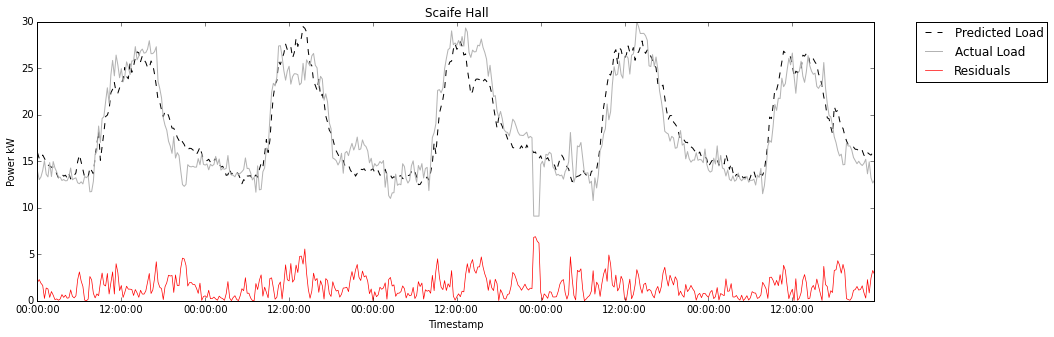

In [218]:
t=data["Timestamp"][start:stop];
fig = plt.figure(figsize=(15,5)) # A 20 inch x 20 inch figure box
plt.plot(t[96*23:96*28],Load[96*23:96*28]/1000.,ls='--',color = 'k',label='Predicted Load',linewidth=1)
plt.plot(t[96*23:96*28],Y[96*23:96*28]/1000.,c='0.7',label='Actual Load')
plt.plot(t[96*23:96*28],(rss[96*23:96*28]/1000.),color = 'r',ls='-',label='Residuals',linewidth=0.7)
plt.title('Scaife Hall')
plt.xlabel('Timestamp')
plt.ylabel('Power kW')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)